# Vector store

In [1]:
#!pip uninstall -y -q gensim
!pip install -q gensim

In [2]:
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence
from gensim.models import KeyedVectors
import heapq
from collections import defaultdict, namedtuple
import numpy as np
from numpy import float32 as FLOAT_TYPE



In [3]:
# 1. Parameters
VECTOR_SIZE = 100
WINDOW      = 5
MIN_COUNT   = 5
WORKERS     = 4
MAX_WORDS_IN_BATCH = 1000

### CustomLineSentence

In [4]:
import itertools
from gensim import utils

class CustomLineSentence:
    def __init__(self, source):
        self.source = source

    def __iter__(self):
        """Iterate through the lines in the source."""
        with utils.open(self.source, 'rb') as fin:
            for line in itertools.islice(fin, None):
                line = utils.to_unicode(line).split()
                i = 0
                while i < len(line):
                    yield line[i: i + MAX_WORDS_IN_BATCH]
                    i += MAX_WORDS_IN_BATCH


In [5]:
# 2. Load the text8 corpus as a stream of sentences
sentences = CustomLineSentence('data/text8')

print("Number of sentences:", len(list(sentences)))

Number of sentences: 17006


In [6]:
print("Type of 'sentences':", type(sentences))
print("What we got from 'sentences':")
for i, s in enumerate(itertools.islice(sentences, 3)):
    print(f"Sentence {i+1}:", s)

    print("Length of sentence:", len(s))
    


Type of 'sentences': <class '__main__.CustomLineSentence'>
What we got from 'sentences':
Sentence 1: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english', 'revolution', 'and', 'the', 'sans', 'culottes', 'of', 'the', 'french', 'revolution', 'whilst', 'the', 'term', 'is', 'still', 'used', 'in', 'a', 'pejorative', 'way', 'to', 'describe', 'any', 'act', 'that', 'used', 'violent', 'means', 'to', 'destroy', 'the', 'organization', 'of', 'society', 'it', 'has', 'also', 'been', 'taken', 'up', 'as', 'a', 'positive', 'label', 'by', 'self', 'defined', 'anarchists', 'the', 'word', 'anarchism', 'is', 'derived', 'from', 'the', 'greek', 'without', 'archons', 'ruler', 'chief', 'king', 'anarchism', 'as', 'a', 'political', 'philosophy', 'is', 'the', 'belief', 'that', 'rulers', 'are', 'unnecessary', 'and', 'should', 'be', 'abolished', 'although', 'there', 'are', 'differing', 

## Custom Doc2Vec Class
Use Gensim's Doc2Vec and TaggedDocument to build and use document vectors.

In [7]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

class CustomDoc2Vec:
    def __init__(self, documents, vector_size=100, window=5, min_count=5, epochs=5, workers=4):
        tagged_docs = [TaggedDocument(words=doc, tags=[i]) for i, doc in enumerate(documents)]
        self.model = Doc2Vec(tagged_docs, vector_size=vector_size, window=window,
                          min_count=min_count, epochs=epochs, workers=workers)

    def infer_vector(self, document):
        return self.model.infer_vector(document)

    def most_similar(self, positive, topn=10):
        return self.model.dv.most_similar(positive, topn=topn)

    def save(self, path):
        self.model.save(path)

    @classmethod
    def load(cls, path):
        m = Doc2Vec.load(path)
        obj = cls([])
        obj.model = m
        return obj

## Document Vector Store
Build document embeddings and search functionality

In [8]:
import numpy as np
from numpy.linalg import norm

class DocumentVectorStore:
    def __init__(self, documents, embedding_model=None):
        """documents: list of token lists or raw text strings"""
        self.raw_documents = documents
        # tokenize if raw strings
        self.tokenized_docs = [doc.split() if isinstance(doc, str) else doc for doc in documents]
        # assign or train word embedding model
        if embedding_model is None:
            from gensim.models import Word2Vec
            self.model = Word2Vec(self.tokenized_docs, vector_size=VECTOR_SIZE, window=WINDOW, min_count=MIN_COUNT, workers=WORKERS)
        else:
            self.model = embedding_model
        # build document embeddings
        self.build_doc_embeddings()

    def build_doc_embeddings(self):
        """Compute document embeddings by averaging word vectors"""
        embeddings = []
        for tokens in self.tokenized_docs:
            vecs = [self.model.wv[word] for word in tokens if word in self.model.wv]
            if vecs:
                doc_vec = np.mean(vecs, axis=0)
            else:
                doc_vec = np.zeros(self.model.vector_size)
            embeddings.append(doc_vec)
        self.doc_embeddings = np.vstack(embeddings)
    
    def search(self, query, topn=5):
        """Return topn most similar documents for a query (tokens or string)"""
        if isinstance(query, str):
            tokens = query.split()
        else:
            tokens = query
            vecs = [self.model.wv[word] for word in tokens if word in self.model.wv]
        if vecs:
            q_vec = np.mean(vecs, axis=0)
        else:
            q_vec = np.zeros(self.model.vector_size)
        # cosine similarity
        sims = self.doc_embeddings.dot(q_vec) / (norm(self.doc_embeddings, axis=1) * norm(q_vec) + 1e-9)
        idx = np.argsort(-sims)[:topn]
        
        return [(i, float(sims[i])) for i in idx]


In [ ]:
sentences = list(sentences)

print("Number of documents:", len(sentences))

def _load_without_rebuild(cls, path):
    m = Doc2Vec.load(path)
    obj = cls.__new__(cls)
    obj.model = m
    return obj

CustomDoc2Vec.load = classmethod(_load_without_rebuild)
# Train our CustomDoc2Vec model
doc2vec_model = CustomDoc2Vec(
    documents=sentences,
    vector_size=VECTOR_SIZE,
    window=WINDOW,
    min_count=MIN_COUNT,
    epochs=5,
    workers=WORKERS
)

# Save and reload the Doc2Vec model
doc2vec_model.save('./models/custom_doc2vec.model')
loaded_doc2vec = CustomDoc2Vec.load('./models/custom_doc2vec.model')

# Build a DocumentVectorStore using the trained Doc2Vec embeddings
doc_store = DocumentVectorStore(sentences, embedding_model=loaded_doc2vec.model)

# testing search
query_doc = sentences[0]
results = doc_store.search(query_doc, topn=5)
print("Top 5 similar documents (index, similarity):", results)


Number of documents: 17006
negative
Top 5 similar documents (index, similarity): [(0, 1.0000001192092896), (14411, 0.9790804386138916), (12080, 0.9789229035377502), (570, 0.9786602258682251), (14412, 0.9785082936286926)]


In [10]:
import textwrap

# join all words into one long string
text = " ".join(query_doc)

# wrap at 80 chars per line
print(textwrap.fill(text, width=80))

anarchism originated as a term of abuse first used against early working class
radicals including the diggers of the english revolution and the sans culottes
of the french revolution whilst the term is still used in a pejorative way to
describe any act that used violent means to destroy the organization of society
it has also been taken up as a positive label by self defined anarchists the
word anarchism is derived from the greek without archons ruler chief king
anarchism as a political philosophy is the belief that rulers are unnecessary
and should be abolished although there are differing interpretations of what
this means anarchism also refers to related social movements that advocate the
elimination of authoritarian institutions particularly the state the word
anarchy as most anarchists use it does not imply chaos nihilism or anomie but
rather a harmonious anti authoritarian society in place of what are regarded as
authoritarian political structures and coercive economic institutio

In [11]:
query_doc = sentences[12]
# join all words into one long string
text = " ".join(query_doc)

# wrap at 80 chars per line
print(textwrap.fill(text, width=80))

experience however in practice many autistic people have difficulty with working
in groups which impairs them even in the most technical of situations autistic
adults temple grandin one of the more successful adults with autism photograph
courtesy joshua nathaniel pritikin and william lawrence jarrold some autistic
adults are able to work successfully in mainstream jobs usually those with high
functioning autism or asperger s syndrome nevertheless communication and social
problems often cause difficulties in many areas of the autistic s life other
autistics are capable of employment in sheltered workshops under the supervision
of managers trained in working with persons with disabilities a nurturing
environment at home at school and later in job training and at work helps
autistic people continue to learn and to develop throughout their lives some
argue that the internet allows autistic individuals to communicate and form
online communities in addition to being able to find occupations

# We want to use PCA, WHY.

PCA (Principal Component Analysis) is used to reduce the dimensionality of high-dimensional data, such as embeddings, while preserving as much of the original information (variance) as possible.

We are going to give it `n_components=3` to reduce the embeddings to 3 dimensions.

In my test case, we just test the first 100 words.

Also, what I can see when I look at the data is that we have a lot of words that are stopwords. We are going to want to remove them.

(71290, 100)


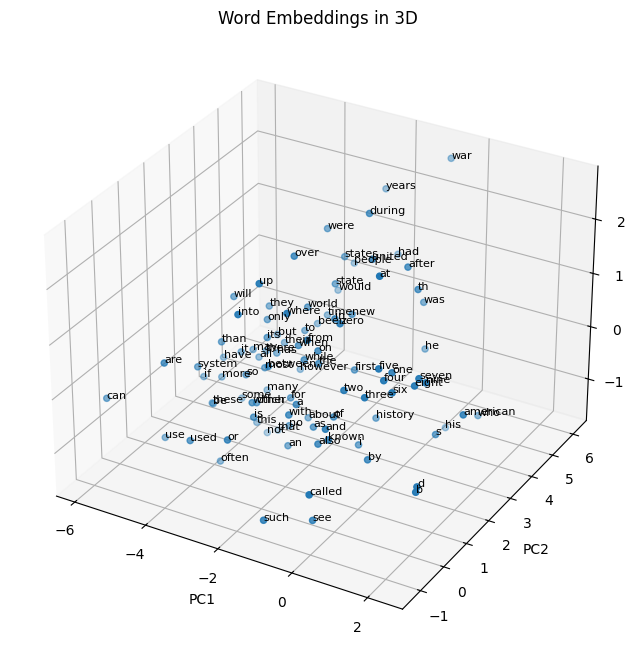

In [12]:
from sklearn.decomposition import PCA

weights = doc2vec_model.model.wv.vectors

print(weights.shape)  # (number of words, vector size)
import matplotlib.pyplot as plt

# Reduce vectors to 3D
pca = PCA(n_components=3)
weights_3d = pca.fit_transform(weights)

# Plot the first 100 words in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(weights_3d[:100, 0], weights_3d[:100, 1], weights_3d[:100, 2])

# Annotate points with words
words = list(doc2vec_model.model.wv.index_to_key)
for i in range(100):
    ax.text(weights_3d[i, 0], weights_3d[i, 1], weights_3d[i, 2], words[i], size=8)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.title('Word Embeddings in 3D')
plt.show()


(17006, 100)


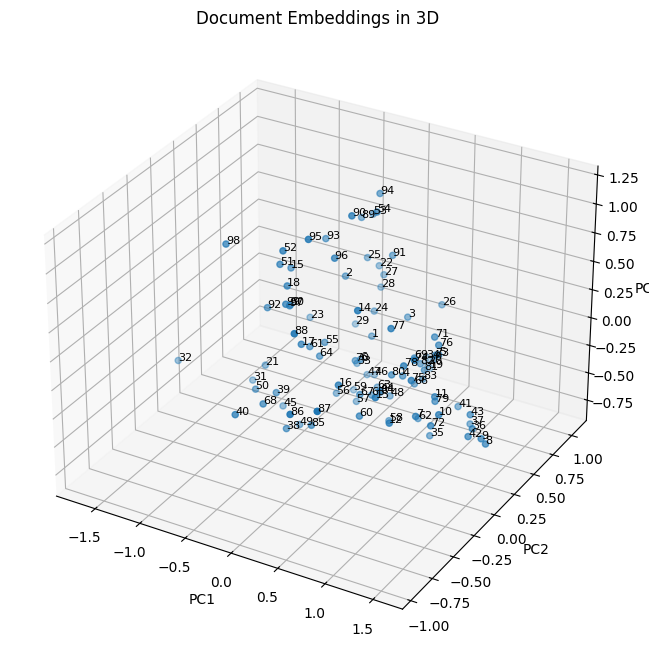

In [13]:
# Use PCA to reduce document embeddings to 3D and plot them

# Get document embeddings from doc_store
doc_embeddings = doc_store.doc_embeddings

print(doc_embeddings.shape)  # (number of documents, vector size)

# Reduce to 3D
pca = PCA(n_components=3)
doc_emb_3d = pca.fit_transform(doc_embeddings)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(doc_emb_3d[:100, 0], doc_emb_3d[:100, 1], doc_emb_3d[:100, 2])

# Annotate points with document indices
for i in range(100):
    ax.text(doc_emb_3d[i, 0], doc_emb_3d[i, 1], doc_emb_3d[i, 2], str(i), size=8)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.title('Document Embeddings in 3D')
plt.show()